# Chapter 10 -- Introduction to Artificial Neural Networks with Keras

## Setup

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is requried
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figure
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Matplotlib is building the font cache; this may take a moment.


## The Perceptron

In [12]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target==0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [13]:
y_pred

array([1])

Saving figure perceptron_iris_plot


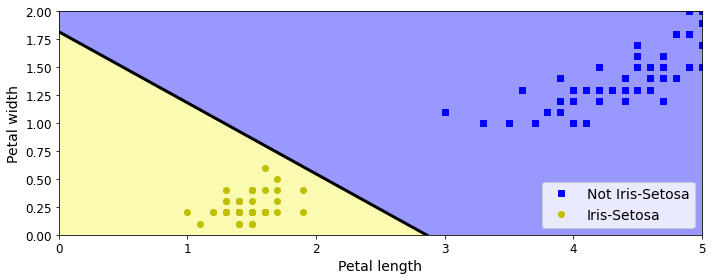

In [40]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=(custom_cmap))
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [41]:
# Activation functions

In [51]:
def sigmoid(z):
    return 1/ (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z , eps=0.00001):
    return (f(z + eps) - f(z - eps))/ (2*eps)

Saving figure activation_functions_plot


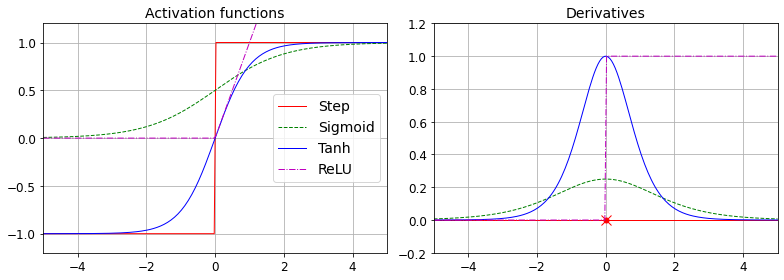

In [58]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=1, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=1, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=1, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=1, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## XOR classification with MLP of perceptron/sigmoid

In [77]:
def heaviside(z): # for Perceptron
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

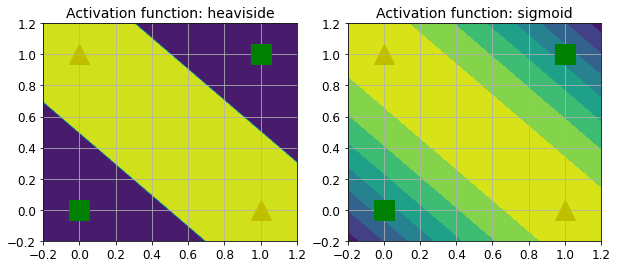

In [89]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)
plt.show()

## Implementing MLPs with Keras

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.3.0'

In [5]:
keras.__version__

'2.4.0'

In [20]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [21]:
X_train_full.shape

(60000, 28, 28)

In [22]:
X_train_full.dtype

dtype('uint8')

In [23]:
X_valid, X_train = X_train_full[:5000]/ 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [178]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

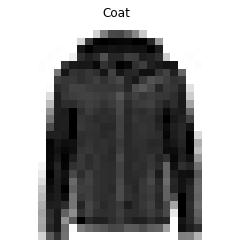

In [179]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.title(class_names[y_train[0]], fontsize=12)
plt.show()

In [180]:
X_valid.shape

(5000, 28, 28)

In [181]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


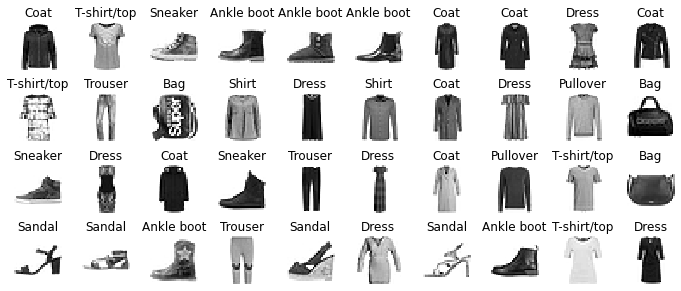

In [182]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [183]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) #X.reshape(-1,1)
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # 1 neuron per class

In [184]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [185]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), #X.reshape(-1,1)
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") # 1 neuron per class
])

In [186]:
model.summary() # the first hidden layer: 784 x 300 (weights) + 300 (bias)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


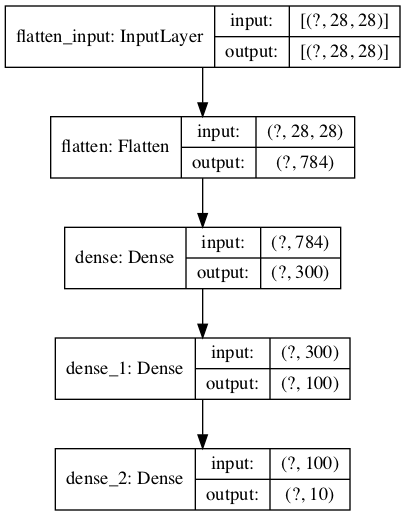

In [187]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [188]:
model.layers

In [189]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [190]:
model.get_layer('dense') is hidden1

True

In [191]:
weights, biases = hidden1.get_weights()

In [192]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [193]:
weights.shape

(784, 300)

In [194]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [195]:
biases.shape

(300,)

In [196]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [197]:
history = model.fit(X_train, y_train, epochs=30, 
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4393 - accuracy: 0.8455 - val_loss: 0.5288 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4126 - accuracy: 0.8564 - val_loss: 0.3917 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3940 - accuracy: 0.8619 - val_loss: 0.3755 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3752 - accuracy: 0.8678 - val_loss: 0.3706 - val_accuracy: 0.8724
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3632 - accuracy: 0.8714 - val_loss: 0.3625 - val_accuracy:

In [198]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [199]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [200]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

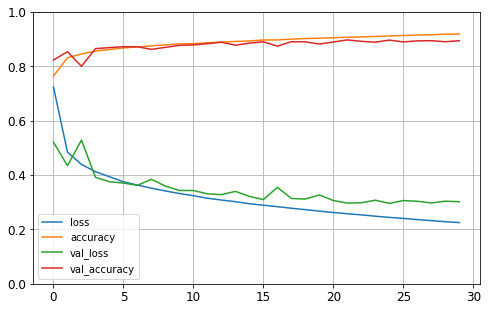

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [202]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 78.1479 - accuracy: 0.8293


[78.14794921875, 0.8292999863624573]

In [204]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [205]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1])

In [206]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [207]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


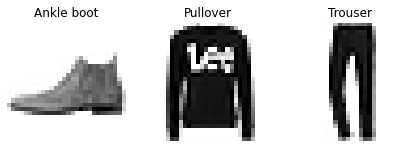

In [210]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Regression MLP using the Sequential API

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_new = X_test[:3]

In [217]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [218]:
# Since the dataset is quite noisy, we just use a single hidden layer with fewer nerons than before to avoid overfitting
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8428 - val_loss: 0.8776
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5852 - val_loss: 0.4970
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4724 - val_loss: 0.4692
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4445 - val_loss: 0.4594
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4324 - val_loss: 0.4495
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4237 - val_loss: 0.4425
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4161 - val_loss: 0.4318
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4082 - val_loss: 0.4311
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4018 - val_loss: 0.4230
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.4195

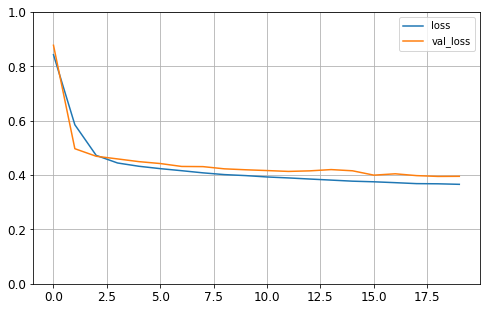

In [220]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Functional API

One example of a nonsequential neural network: Wide & Deep neural network introduced by Heng-Tze Cheng et al. 2016. This architecture makes it possible for the NN to learn both deep pattern (using the deep path) and simple rules (through the short path).

In [221]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [224]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [225]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_4[0][0]         

In [229]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.7020 - val_loss: 0.7687
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7121 - val_loss: 0.6944
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6607 - val_loss: 0.6512
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6229 - val_loss: 0.6208
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5954 - val_loss: 0.5956
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5723 - val_loss: 0.5774
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5547 - val_loss: 0.5602
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5395 - val_loss: 0.5471
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5280 - val_loss: 0.5376
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5182 - val_loss: 0.5283

In [230]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 879us/step - loss: 0.4718


0.47183114290237427

Multiple inputs: send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path. For example, suppose we want to send 5 features through the wide path (features 0 to 4), and six features through the deep path (features 2 to 7)_

In [252]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [253]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [254]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8248 - val_loss: 0.7923
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7055 - val_loss: 0.6450
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6057
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5910 - val_loss: 0.5840
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5690 - val_loss: 0.5665
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5508 - val_loss: 0.5542
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5373 - val_loss: 0.5430
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5256 - val_loss: 0.5343
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5168 - val_loss: 0.5270
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5093 - val_loss: 0.5214

Adding an auxilary outputs for regularization:

In [255]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [256]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [259]:
# care more about the main output than about the auxiliary output > different loss weights 
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

In [260]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9284 - main_output_loss: 0.8219 - aux_output_loss: 1.8864 - val_loss: 0.7224 - val_main_output_loss: 0.6661 - val_aux_output_loss: 1.2291
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5907 - main_output_loss: 0.5360 - aux_output_loss: 1.0830 - val_loss: 0.5508 - val_main_output_loss: 0.4986 - val_aux_output_loss: 1.0205
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5178 - main_output_loss: 0.4722 - aux_output_loss: 0.9281 - val_loss: 0.5198 - val_main_output_loss: 0.4793 - val_aux_output_loss: 0.8843
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4937 - main_output_loss: 0.4573 - aux_output_loss: 0.8208 - val_loss: 0.5078 - val_main_output_loss: 0.4757 - val_aux_output_loss: 0.7963
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4761 - main_output_loss: 0.4461 - aux_output_loss: 0.7464 - val_loss

In [261]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.3793 - main_output_loss: 0.3667 - aux_output_loss: 0.4929


In [262]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

## Subclassing API to build Dynamic models

Subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the ```call()``` method.

In [266]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [269]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # handles standard args(e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [271]:
model.summary() # without any info. on how the layers are connected to each other

Model: "wide_and_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  210       
_________________________________________________________________
dense_5 (Dense)              multiple                  930       
_________________________________________________________________
dense_6 (Dense)              multiple                  36        
_________________________________________________________________
dense_7 (Dense)              multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [270]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                   validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 4ms/step - loss: 2.1377 - output_1_loss: 1.9300 - output_2_loss: 4.0068 - val_loss: 1.0631 - val_output_1_loss: 0.8288 - val_output_2_loss: 3.1725
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.9125 - output_1_loss: 0.7249 - output_2_loss: 2.6008 - val_loss: 0.8148 - val_output_1_loss: 0.6557 - val_output_2_loss: 2.2465
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7656 - output_1_loss: 0.6357 - output_2_loss: 1.9353 - val_loss: 0.7374 - val_output_1_loss: 0.6142 - val_output_2_loss: 1.8463
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7043 - output_1_loss: 0.5994 - output_2_loss: 1.6482 - val_loss: 0.6974 - val_output_1_loss: 0.5923 - val_output_2_loss: 1.6432
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.6687 - output_1_loss: 0.5769 - output_2_loss: 1.4948 - val_loss: 0.6679 - val_output_1_loss: 0.5734 - val_ou

# Saving and Restoring

In [272]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [274]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [277]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8688 - val_loss: 0.7796
Epoch 2/10
363/363 [==============================] - 0s 993us/step - loss: 0.7040 - val_loss: 0.6453
Epoch 3/10
363/363 [==============================] - 0s 947us/step - loss: 0.6180 - val_loss: 0.6001
Epoch 4/10
363/363 [==============================] - 0s 941us/step - loss: 0.5762 - val_loss: 0.5717
Epoch 5/10
363/363 [==============================] - 0s 999us/step - loss: 0.5496 - val_loss: 0.5476
Epoch 6/10
363/363 [==============================] - 0s 984us/step - loss: 0.5267 - val_loss: 0.5303
Epoch 7/10
363/363 [==============================] - 0s 945us/step - loss: 0.5100 - val_loss: 0.5157
Epoch 8/10
363/363 [==============================] - 0s 974us/step - loss: 0.4960 - val_loss: 0.5045
Epoch 9/10
363/363 [==============================] - 0s 958us/step - loss: 0.4856 - val_loss: 0.4955
Epoch 10/10
162/162 [==============================] - 0s 759us/step - loss: 0.4842


In [280]:
model.save("my_keras_model.h5") 
# HDF5 format to save both the model's architecture and the values of all the model parameters.
# Also saves the optimizer and its hyperparameters.

In [284]:
model = keras.models.load_model("my_keras_model.h5")

In [285]:
model.predict(X_new)

array([[0.7036089],
       [1.5775751],
       [2.8617046]], dtype=float32)

In [286]:
model.save_weights("my_keras_weights.h5")

In [287]:
model.load_weights("my_keras_weights.h5")

## Using callbacks during Traning

In [296]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [300]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])


In [302]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
# only save your model when its performance on the validation set is the best so far.
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                               save_best_only=True) 
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # roll back to best model


Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5101 - val_loss: 0.5200
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.5073
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4860 - val_loss: 0.4979
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4763 - val_loss: 0.4907
Epoch 5/10
363/363 [==============================] - 0s 979us/step - loss: 0.4681 - val_loss: 0.4828
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4608 - val_loss: 0.4774
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4547 - val_loss: 0.4717
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4492 - val_loss: 0.4669
Epoch 9/10
363/363 [==============================] - 0s 984us/step - loss: 0.4445 - val_loss: 0.4631
Epoch 10/10
363/363 [==============================] - ETA: 0s - loss: 0.439 - 0s 968us/step - l

In [308]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                 restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40,
                   validation_data=(X_valid, y_valid),
                   callbacks=[early_stopping_cb])
model = keras.models.load_model("my_keras_model.h5")

Epoch 1/40
363/363 [==============================] - 0s 1ms/step - loss: 0.3854 - val_loss: 0.4140
Epoch 2/40
363/363 [==============================] - 0s 983us/step - loss: 0.3844 - val_loss: 0.4114
Epoch 3/40
363/363 [==============================] - 0s 936us/step - loss: 0.3834 - val_loss: 0.4108
Epoch 4/40
363/363 [==============================] - 0s 965us/step - loss: 0.3827 - val_loss: 0.4109
Epoch 5/40
363/363 [==============================] - 0s 994us/step - loss: 0.3817 - val_loss: 0.4094
Epoch 6/40
363/363 [==============================] - 0s 948us/step - loss: 0.3806 - val_loss: 0.4091
Epoch 7/40
363/363 [==============================] - 0s 952us/step - loss: 0.3798 - val_loss: 0.4074
Epoch 8/40
363/363 [==============================] - 0s 954us/step - loss: 0.3786 - val_loss: 0.4066
Epoch 9/40
363/363 [==============================] - 0s 948us/step - loss: 0.3776 - val_loss: 0.4059
Epoch 10/40
363/363 [==============================] - 0s 962us/step - loss: 0.3772 

In [315]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))

val_train_ration_cb = PrintValTrainRatioCallback()
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[val_train_ration_cb])

Epoch 1/10
351/363 [============================>.] - ETA: 0s - loss: 0.3641
val/train: 1.09
363/363 [==============================] - 0s 1ms/step - loss: 0.3637 - val_loss: 0.3961
Epoch 2/10
344/363 [===========================>..] - ETA: 0s - loss: 0.3639
val/train: 1.08
363/363 [==============================] - 0s 958us/step - loss: 0.3631 - val_loss: 0.3936
Epoch 3/10
344/363 [===========================>..] - ETA: 0s - loss: 0.3655
val/train: 1.09
363/363 [==============================] - 0s 954us/step - loss: 0.3624 - val_loss: 0.3934
Epoch 4/10
348/363 [===========================>..] - ETA: 0s - loss: 0.3611
val/train: 1.09
363/363 [==============================] - 0s 940us/step - loss: 0.3620 - val_loss: 0.3936
Epoch 5/10
326/363 [=========================>....] - ETA: 0s - loss: 0.3598
val/train: 1.09
363/363 [==============================] - 0s 995us/step - loss: 0.3614 - val_loss: 0.3924
Epoch 6/10
349/363 [===========================>..] - ETA: 0s - loss: 0.3636
val/t

In [312]:
# Coursera Class
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(logs.get("val_loss") > 0.4):
            self.stopped_epoch = epoch
            print("\nReached 0.4 validation loss so cancelling training!")
            self.model.stop_training = True
mycallback = myCallback()

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=40,
                   validation_data=(X_valid, y_valid),
                   callbacks=[mycallback])

Epoch 1/40
356/363 [============================>.] - ETA: 0s - loss: 0.3817
Reached 0.4 validation loss so cancelling training!
363/363 [==============================] - 0s 1ms/step - loss: 0.3825 - val_loss: 0.4116


## TensorBoard for Visualization

In [316]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2020_06_07-15_15_22'
run_logdir

'./my_logs/run_2020_10_06-11_22_42'

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [29]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 0s 1ms/step - loss: 1.4905 - val_loss: 0.8458
Epoch 2/30
363/363 [==============================] - 0s 973us/step - loss: 0.7623 - val_loss: 0.7172
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6803 - val_loss: 0.6600
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6294 - val_loss: 0.6193
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5930 - val_loss: 0.5879
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5639 - val_loss: 0.5647
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5408 - val_loss: 0.5443
Epoch 8/30
363/363 [==============================] - 0s 960us/step - loss: 0.5219 - val_loss: 0.5289
Epoch 9/30
363/363 [==============================] - 0s 939us/step - loss: 0.5065 - val_loss: 0.5162
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4943 - val_loss: 

In [3]:
!tree ./my_logs

./my_logs
└── run_2020_10_06-10_25_07
    ├── train
    │   ├── events.out.tfevents.1601994481.HwanpyoKims-MacBook-Pro.local.94413.584461.v2
    │   ├── events.out.tfevents.1601994482.HwanpyoKims-MacBook-Pro.local.profile-empty
    │   └── plugins
    │       └── profile
    │           └── 2020_10_06_10_28_02
    │               ├── HwanpyoKims-MacBook-Pro.local.input_pipeline.pb
    │               ├── HwanpyoKims-MacBook-Pro.local.kernel_stats.pb
    │               ├── HwanpyoKims-MacBook-Pro.local.memory_profile.json.gz
    │               ├── HwanpyoKims-MacBook-Pro.local.overview_page.pb
    │               ├── HwanpyoKims-MacBook-Pro.local.tensorflow_stats.pb
    │               ├── HwanpyoKims-MacBook-Pro.local.trace.json.gz
    │               └── HwanpyoKims-MacBook-Pro.local.xplane.pb
    └── validation
        └── events.out.tfevents.1601994482.HwanpyoKims-MacBook-Pro.local.94413.585222.v2

6 directories, 10 files


To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:
```
$ tensorboard --logdir=./my_logs --port=6006
```
You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can use TensorBoard directly within jupyter:

In [4]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_10_06-11_22_56'

In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 1.8688 - val_loss: 0.7796
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.7040 - val_loss: 0.6453
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6180 - val_loss: 0.6001
Epoch 4/30
363/363 [==============================] - 0s 980us/step - loss: 0.5762 - val_loss: 0.5717
Epoch 5/30
363/363 [==============================] - 0s 936us/step - loss: 0.5496 - val_loss: 0.5476
Epoch 6/30
363/363 [==============================] - 0s 961us/step - loss: 0.5267 - val_loss: 0.5303
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5100 - val_loss: 0.5157
Epoch 8/30
363/363 [==============================] - 0s 963us/step - loss: 0.4960 - val_loss: 0.5045
Epoch 9/30
363/363 [==============================] - 0s 965us/step - loss: 0.4856 - val_loss: 0.4955
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4771 - val_lo

In [34]:
!tree ./my_logs

./my_logs
├── run_2020_10_06-10_25_07
│   ├── train
│   │   ├── events.out.tfevents.1601994481.HwanpyoKims-MacBook-Pro.local.94413.584461.v2
│   │   ├── events.out.tfevents.1601994482.HwanpyoKims-MacBook-Pro.local.profile-empty
│   │   └── plugins
│   │       └── profile
│   │           └── 2020_10_06_10_28_02
│   │               ├── HwanpyoKims-MacBook-Pro.local.input_pipeline.pb
│   │               ├── HwanpyoKims-MacBook-Pro.local.kernel_stats.pb
│   │               ├── HwanpyoKims-MacBook-Pro.local.memory_profile.json.gz
│   │               ├── HwanpyoKims-MacBook-Pro.local.overview_page.pb
│   │               ├── HwanpyoKims-MacBook-Pro.local.tensorflow_stats.pb
│   │               ├── HwanpyoKims-MacBook-Pro.local.trace.json.gz
│   │               └── HwanpyoKims-MacBook-Pro.local.xplane.pb
│   └── validation
│       └── events.out.tfevents.1601994482.HwanpyoKims-MacBook-Pro.local.94413.585222.v2
├── run_2020_10_06-11_21_19
│   ├── train
│   │   ├── events.out.tfevents.1601997747

In [35]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9530), started 0:27:45 ago. (Use '!kill 9530' to kill it.)

## Fine-Tuning Neural Network Hyperparameters

In [7]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [9]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [10]:
keras_reg.fit(X_train, y_train, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 1.0566 - val_loss: 0.7676
Epoch 2/100
363/363 [==============================] - 0s 900us/step - loss: 0.6914 - val_loss: 0.6127
Epoch 3/100
363/363 [==============================] - 0s 938us/step - loss: 0.5818 - val_loss: 0.5436
Epoch 4/100
363/363 [==============================] - 0s 891us/step - loss: 0.5167 - val_loss: 0.5164
Epoch 5/100
363/363 [==============================] - 0s 888us/step - loss: 0.4896 - val_loss: 0.4981
Epoch 6/100
363/363 [==============================] - 0s 926us/step - loss: 0.4758 - val_loss: 0.4882
Epoch 7/100
363/363 [==============================] - 0s 930us/step - loss: 0.4662 - val_loss: 0.4783
Epoch 8/100
363/363 [==============================] - 0s 906us/step - loss: 0.4583 - val_loss: 0.4724
Epoch 9/100
363/363 [==============================] - 0s 936us/step - loss: 0.4525 - val_loss: 0.4673
Epoch 10/100
363/363 [==============================] - 0s 915us/step - los

363/363 [==============================] - 0s 934us/step - loss: 0.3505 - val_loss: 0.3862
Epoch 81/100
363/363 [==============================] - 0s 971us/step - loss: 0.3497 - val_loss: 0.3864
Epoch 82/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3492 - val_loss: 0.3913
Epoch 83/100
363/363 [==============================] - 0s 968us/step - loss: 0.3492 - val_loss: 0.3876
Epoch 84/100
363/363 [==============================] - 0s 883us/step - loss: 0.3484 - val_loss: 0.3862
Epoch 85/100
363/363 [==============================] - 0s 909us/step - loss: 0.3475 - val_loss: 0.3926
Epoch 86/100
363/363 [==============================] - 0s 951us/step - loss: 0.3474 - val_loss: 0.3860
Epoch 87/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3465 - val_loss: 0.3852
Epoch 88/100
363/363 [==============================] - 0s 908us/step - loss: 0.3465 - val_loss: 0.3836
Epoch 89/100
363/363 [==============================] - 0s 916us/step - loss: 0.3

**Warning**: RuntimeError: "Cannot clone object ..." because of keras.wrappers https://github.com/keras-team/keras/issues/13586 

**Solution**: pip install --upgrade tensorflow==2.3.0 Keras==2.4.3 scikit-learn==0.21.2 pandas==0.25.3 numpy==1.18.5

In [11]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=1)
# RandomizedSearchCV uses K-fold cross-validation, so it does not use X_valid and y_valid, 
# which are only used for early stopping
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data=(X_valid, y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 0s 1ms/step - loss: 3.1309 - val_loss: 1.5009
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9702 - val_loss: 0.7044
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6105 - val_loss: 0.5690
Epoch 4/100
242/242 [==============================] - 0s 981us/step - loss: 0.5412 - val_loss: 0.5437
Epoch 5/100
242/242 [==============================] - 0s 984us/step - loss: 0.5271 - val_loss: 0.5389
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5237 - val_loss: 0.5377
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5225 - val_loss: 0.5371
Epoch 8/100
242/242 [==============================] - 0s 972us/step - loss: 0.5216 - val_loss: 0.5369
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5213 - val_loss: 0.5364
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5210 - val_loss: 0.

242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.5389
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.5399
Epoch 58/100
242/242 [==============================] - 0s 984us/step - loss: 0.5055 - val_loss: 0.5386
Epoch 59/100
242/242 [==============================] - 0s 991us/step - loss: 0.5060 - val_loss: 0.5387
Epoch 60/100
242/242 [==============================] - 0s 965us/step - loss: 0.5054 - val_loss: 0.5394
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.5393
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.5393
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.5396
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5050 - val_loss: 0.5373
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_

242/242 [==============================] - 0s 1ms/step - loss: 0.5278 - val_loss: 0.5442
Epoch 36/100
242/242 [==============================] - 0s 945us/step - loss: 0.5276 - val_loss: 0.5438
Epoch 37/100
242/242 [==============================] - 0s 927us/step - loss: 0.5273 - val_loss: 0.5438
Epoch 38/100
242/242 [==============================] - 0s 971us/step - loss: 0.5270 - val_loss: 0.5431
Epoch 39/100
242/242 [==============================] - 0s 965us/step - loss: 0.5270 - val_loss: 0.5423
Epoch 40/100
242/242 [==============================] - 0s 943us/step - loss: 0.5267 - val_loss: 0.5417
Epoch 41/100
242/242 [==============================] - 0s 933us/step - loss: 0.5265 - val_loss: 0.5423
Epoch 42/100
242/242 [==============================] - 0s 928us/step - loss: 0.5262 - val_loss: 0.5421
Epoch 43/100
242/242 [==============================] - 0s 957us/step - loss: 0.5264 - val_loss: 0.5410
Epoch 44/100
242/242 [==============================] - 0s 970us/step - loss: 0

242/242 [==============================] - 0s 1ms/step - loss: 0.5106 - val_loss: 0.5813
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5268 - val_loss: 0.5417
Epoch 11/100
242/242 [==============================] - 0s 939us/step - loss: 0.5328 - val_loss: 0.5450
Epoch 12/100
242/242 [==============================] - 0s 917us/step - loss: 0.5379 - val_loss: 0.5390
Epoch 13/100
242/242 [==============================] - 0s 962us/step - loss: 0.5168 - val_loss: 0.5396
Epoch 14/100
242/242 [==============================] - 0s 964us/step - loss: 0.5244 - val_loss: 0.5358
Epoch 15/100
242/242 [==============================] - 0s 957us/step - loss: 0.5072 - val_loss: 0.5497
Epoch 16/100
242/242 [==============================] - 0s 996us/step - loss: 0.5125 - val_loss: 0.5368
Epoch 17/100
242/242 [==============================] - 0s 971us/step - loss: 0.5098 - val_loss: 0.5479
Epoch 18/100
242/242 [==============================] - 0s 935us/step - loss: 0.5

242/242 [==============================] - 0s 1ms/step - loss: 0.4336 - val_loss: 0.4531
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4327 - val_loss: 0.4524
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4312 - val_loss: 0.4509
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4299 - val_loss: 0.4504
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4286 - val_loss: 0.4498
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4273 - val_loss: 0.4490
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4261 - val_loss: 0.4479
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4250 - val_loss: 0.4469
Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4238 - val_loss: 0.4458
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4228 - val_loss: 

Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4568 - val_loss: 0.4877
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4542 - val_loss: 0.4847
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4517 - val_loss: 0.4823
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4496 - val_loss: 0.4800
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4473 - val_loss: 0.4777
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4451 - val_loss: 0.4756
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4430 - val_loss: 0.4736
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4410 - val_loss: 0.4714
Epoch 39/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4390 - val_loss: 0.4692
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4373

242/242 [==============================] - 0s 1ms/step - loss: 0.5880 - val_loss: 0.5906
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5754 - val_loss: 0.5793
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5633 - val_loss: 0.5690
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5524 - val_loss: 0.5598
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5425 - val_loss: 0.5507
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5331 - val_loss: 0.5427
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5249 - val_loss: 0.5353
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5173 - val_loss: 0.5282
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5098 - val_loss: 0.5221
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5036 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.3908 - val_loss: 0.4166
Epoch 91/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3898 - val_loss: 0.4161
Epoch 92/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3894 - val_loss: 0.4161
Epoch 93/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3887 - val_loss: 0.4152
Epoch 94/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3882 - val_loss: 0.4148
Epoch 95/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3878 - val_loss: 0.4141
Epoch 96/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3869 - val_loss: 0.4142
Epoch 97/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3865 - val_loss: 0.4137
Epoch 98/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3860 - val_loss: 0.4128
Epoch 99/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3855 - val_loss: 

Epoch 70/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4638 - val_loss: 0.4811
Epoch 71/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4625 - val_loss: 0.4792
Epoch 72/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4610 - val_loss: 0.4778
Epoch 73/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4596 - val_loss: 0.4763
Epoch 74/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4581 - val_loss: 0.4763
Epoch 75/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4569 - val_loss: 0.4744
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4553 - val_loss: 0.4726
Epoch 77/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4543 - val_loss: 0.4713
Epoch 78/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4531 - val_loss: 0.4700
Epoch 79/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4518

242/242 [==============================] - 0s 1ms/step - loss: 0.4345 - val_loss: 0.4708
Epoch 50/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4337 - val_loss: 0.4699
Epoch 51/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4328 - val_loss: 0.4692
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4320 - val_loss: 0.4684
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4311 - val_loss: 0.4676
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4304 - val_loss: 0.4668
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4295 - val_loss: 0.4663
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4286 - val_loss: 0.4656
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4280 - val_loss: 0.4650
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4272 - val_loss: 

Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5060 - val_loss: 0.5238
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5018 - val_loss: 0.5203
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4980 - val_loss: 0.5168
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4942 - val_loss: 0.5136
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4905 - val_loss: 0.5103
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4871 - val_loss: 0.5072
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4838 - val_loss: 0.5044
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4805 - val_loss: 0.5018
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4775 - val_loss: 0.4988
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4742

242/242 [==============================] - 0s 1ms/step - loss: 0.5228 - val_loss: 0.5401
Epoch 9/100
242/242 [==============================] - 0s 921us/step - loss: 0.5229 - val_loss: 0.5390
Epoch 10/100
242/242 [==============================] - 0s 989us/step - loss: 0.5228 - val_loss: 0.5399
Epoch 11/100
242/242 [==============================] - 0s 950us/step - loss: 0.5207 - val_loss: 0.5410
Epoch 12/100
242/242 [==============================] - 0s 954us/step - loss: 0.5209 - val_loss: 0.5368
Epoch 13/100
242/242 [==============================] - 0s 927us/step - loss: 0.5224 - val_loss: 0.5389
Epoch 14/100
242/242 [==============================] - 0s 949us/step - loss: 0.5219 - val_loss: 0.5361
Epoch 15/100
242/242 [==============================] - 0s 951us/step - loss: 0.5211 - val_loss: 0.5432
Epoch 16/100
242/242 [==============================] - 0s 907us/step - loss: 0.5226 - val_loss: 0.5369
Epoch 17/100
242/242 [==============================] - 0s 936us/step - loss: 0.

Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3785 - val_loss: 0.4172
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3775 - val_loss: 0.4153
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3762 - val_loss: 0.4048
Epoch 30/100
242/242 [==============================] - 0s 986us/step - loss: 0.3729 - val_loss: 0.4111
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3724 - val_loss: 0.4104
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3717 - val_loss: 0.4039
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3702 - val_loss: 0.4023
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3686 - val_loss: 0.4020
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3662 - val_loss: 0.4086
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.36

242/242 [==============================] - 0s 1ms/step - loss: 0.4244 - val_loss: 0.4528
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4178 - val_loss: 0.4493
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4135 - val_loss: 0.4447
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4089 - val_loss: 0.4473
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4053 - val_loss: 0.4364
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4005 - val_loss: 0.4330
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3978 - val_loss: 0.4342
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3934 - val_loss: 0.4291
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3914 - val_loss: 0.4465
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3894 - val_loss: 0.

242/242 [==============================] - 0s 963us/step - loss: 0.3165 - val_loss: 0.3817
Epoch 88/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3150 - val_loss: 0.3608
Epoch 89/100
242/242 [==============================] - 0s 976us/step - loss: 0.3116 - val_loss: 0.3573
Epoch 90/100
242/242 [==============================] - 0s 987us/step - loss: 0.3127 - val_loss: 0.3654
Epoch 91/100
242/242 [==============================] - 0s 977us/step - loss: 0.3126 - val_loss: 0.4047
Epoch 92/100
242/242 [==============================] - 0s 976us/step - loss: 0.3193 - val_loss: 0.3682
Epoch 93/100
242/242 [==============================] - 0s 965us/step - loss: 0.3100 - val_loss: 0.3671
Epoch 94/100
242/242 [==============================] - 0s 994us/step - loss: 0.3127 - val_loss: 0.3596
Epoch 95/100
242/242 [==============================] - 0s 966us/step - loss: 0.3389 - val_loss: 0.3826
Epoch 96/100
242/242 [==============================] - 0s 964us/step - loss: 0

242/242 [==============================] - 0s 1ms/step - loss: 0.3151 - val_loss: 0.3961
Epoch 68/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3168 - val_loss: 0.3596
Epoch 69/100
242/242 [==============================] - 0s 988us/step - loss: 0.3103 - val_loss: 0.3652
Epoch 70/100
242/242 [==============================] - 0s 953us/step - loss: 0.3098 - val_loss: 0.3622
Epoch 71/100
242/242 [==============================] - 0s 964us/step - loss: 0.3092 - val_loss: 0.3564
Epoch 72/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3084 - val_loss: 0.4521
Epoch 73/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3083 - val_loss: 0.3568
Epoch 74/100
242/242 [==============================] - 0s 964us/step - loss: 0.3066 - val_loss: 0.3546
Epoch 75/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3107 - val_loss: 0.3564
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3062 - va

242/242 [==============================] - 0s 1ms/step - loss: 0.4815 - val_loss: 0.5015
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4802 - val_loss: 0.5000
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4787 - val_loss: 0.4987
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4773 - val_loss: 0.4971
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4761 - val_loss: 0.4957
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4748 - val_loss: 0.4944
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4735 - val_loss: 0.4934
Epoch 67/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4723 - val_loss: 0.4922
Epoch 68/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4712 - val_loss: 0.4911
Epoch 69/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4700 - val_loss: 

Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5830 - val_loss: 0.6136
Epoch 41/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5784 - val_loss: 0.6097
Epoch 42/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5740 - val_loss: 0.6058
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5697 - val_loss: 0.6017
Epoch 44/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5655 - val_loss: 0.5978
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5612 - val_loss: 0.5937
Epoch 46/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5571 - val_loss: 0.5898
Epoch 47/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5532 - val_loss: 0.5863
Epoch 48/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5493 - val_loss: 0.5826
Epoch 49/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5454

242/242 [==============================] - 0s 1ms/step - loss: 0.6186 - val_loss: 0.6206
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6119 - val_loss: 0.6147
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6057 - val_loss: 0.6089
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5998 - val_loss: 0.6033
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5943 - val_loss: 0.5979
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5890 - val_loss: 0.5929
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5840 - val_loss: 0.5880
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5794 - val_loss: 0.5838
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5749 - val_loss: 0.5797
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.4492 - val_loss: 0.4629
Epoch 100/100
121/121 [==============================] - 0s 617us/step - loss: 0.4381
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2622 - val_loss: 0.6668
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6241 - val_loss: 0.5830
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5626 - val_loss: 0.5492
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5293 - val_loss: 0.5415
Epoch 5/100
242/242 [==============================] - 0s 991us/step - loss: 0.5091 - val_loss: 0.5150
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4945 - val_loss: 0.5022
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4805 - val_loss: 0.4920
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4687 - val_loss: 0.4824
Epoch 9/100
242

242/242 [==============================] - 0s 996us/step - loss: 0.3515 - val_loss: 0.3876
Epoch 79/100
242/242 [==============================] - 0s 995us/step - loss: 0.3485 - val_loss: 0.3853
Epoch 80/100
242/242 [==============================] - 0s 996us/step - loss: 0.3486 - val_loss: 0.3853
Epoch 81/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3486 - val_loss: 0.3805
Epoch 82/100
242/242 [==============================] - 0s 990us/step - loss: 0.3478 - val_loss: 0.3812
Epoch 83/100
242/242 [==============================] - 0s 971us/step - loss: 0.3470 - val_loss: 0.4045
Epoch 84/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3440 - val_loss: 0.3824
Epoch 85/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3446 - val_loss: 0.3790
Epoch 86/100
242/242 [==============================] - 0s 994us/step - loss: 0.3461 - val_loss: 0.3843
Epoch 87/100
242/242 [==============================] - 0s 996us/step - loss: 0.346

242/242 [==============================] - 0s 1ms/step - loss: 0.3658 - val_loss: 0.4132
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3652 - val_loss: 0.4189
Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3652 - val_loss: 0.4108
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3643 - val_loss: 0.4103
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3630 - val_loss: 0.4097
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3620 - val_loss: 0.4128
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3621 - val_loss: 0.4087
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3606 - val_loss: 0.4120
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3611 - val_loss: 0.4079
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3594 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.3811 - val_loss: 0.4022
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3802 - val_loss: 0.4110
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3789 - val_loss: 0.4018
Epoch 39/100
242/242 [==============================] - 0s 990us/step - loss: 0.3773 - val_loss: 0.4055
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3763 - val_loss: 0.4009
Epoch 41/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3732 - val_loss: 0.4042
Epoch 42/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3735 - val_loss: 0.4024
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3731 - val_loss: 0.4058
Epoch 44/100
242/242 [==============================] - 0s 992us/step - loss: 0.3703 - val_loss: 0.4012
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3702 - val_lo

242/242 [==============================] - 0s 952us/step - loss: 0.7327 - val_loss: 0.7403
Epoch 16/100
242/242 [==============================] - 0s 958us/step - loss: 0.7127 - val_loss: 0.7231
Epoch 17/100
242/242 [==============================] - 0s 974us/step - loss: 0.6970 - val_loss: 0.7095
Epoch 18/100
242/242 [==============================] - 0s 933us/step - loss: 0.6845 - val_loss: 0.6984
Epoch 19/100
242/242 [==============================] - 0s 946us/step - loss: 0.6743 - val_loss: 0.6893
Epoch 20/100
242/242 [==============================] - 0s 929us/step - loss: 0.6659 - val_loss: 0.6818
Epoch 21/100
242/242 [==============================] - 0s 987us/step - loss: 0.6589 - val_loss: 0.6753
Epoch 22/100
242/242 [==============================] - 0s 945us/step - loss: 0.6529 - val_loss: 0.6696
Epoch 23/100
242/242 [==============================] - 0s 949us/step - loss: 0.6476 - val_loss: 0.6647
Epoch 24/100
242/242 [==============================] - 0s 947us/step - loss:

Epoch 94/100
242/242 [==============================] - 0s 990us/step - loss: 0.5399 - val_loss: 0.5575
Epoch 95/100
242/242 [==============================] - 0s 970us/step - loss: 0.5394 - val_loss: 0.5570
Epoch 96/100
242/242 [==============================] - 0s 947us/step - loss: 0.5390 - val_loss: 0.5566
Epoch 97/100
242/242 [==============================] - 0s 925us/step - loss: 0.5385 - val_loss: 0.5562
Epoch 98/100
242/242 [==============================] - 0s 968us/step - loss: 0.5380 - val_loss: 0.5557
Epoch 99/100
242/242 [==============================] - 0s 969us/step - loss: 0.5376 - val_loss: 0.5553
Epoch 100/100
121/121 [==============================] - 0s 640us/step - loss: 0.5318
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 7.4602 - val_loss: 6.4099
Epoch 2/100
242/242 [==============================] - 0s 953us/step - loss: 5.6562 - val_loss: 4.8960
Epoch 3/100
242/242 [==============================] - 0s 956us/step - loss: 4.3369 - 

242/242 [==============================] - 0s 951us/step - loss: 0.5525 - val_loss: 0.6025
Epoch 73/100
242/242 [==============================] - 0s 984us/step - loss: 0.5516 - val_loss: 0.6017
Epoch 74/100
242/242 [==============================] - 0s 942us/step - loss: 0.5508 - val_loss: 0.6008
Epoch 75/100
242/242 [==============================] - 0s 949us/step - loss: 0.5501 - val_loss: 0.5999
Epoch 76/100
242/242 [==============================] - 0s 942us/step - loss: 0.5493 - val_loss: 0.5991
Epoch 77/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5485 - val_loss: 0.5980
Epoch 78/100
242/242 [==============================] - 0s 976us/step - loss: 0.5478 - val_loss: 0.5972
Epoch 79/100
242/242 [==============================] - 0s 949us/step - loss: 0.5470 - val_loss: 0.5965
Epoch 80/100
242/242 [==============================] - 0s 937us/step - loss: 0.5463 - val_loss: 0.5959
Epoch 81/100
242/242 [==============================] - 0s 986us/step - loss: 0

242/242 [==============================] - 0s 953us/step - loss: 0.5708 - val_loss: 0.5894
Epoch 51/100
242/242 [==============================] - 0s 984us/step - loss: 0.5698 - val_loss: 0.5884
Epoch 52/100
242/242 [==============================] - 0s 980us/step - loss: 0.5689 - val_loss: 0.5875
Epoch 53/100
242/242 [==============================] - 0s 954us/step - loss: 0.5679 - val_loss: 0.5866
Epoch 54/100
242/242 [==============================] - 0s 956us/step - loss: 0.5670 - val_loss: 0.5856
Epoch 55/100
242/242 [==============================] - 0s 956us/step - loss: 0.5661 - val_loss: 0.5848
Epoch 56/100
242/242 [==============================] - 0s 991us/step - loss: 0.5652 - val_loss: 0.5838
Epoch 57/100
242/242 [==============================] - 0s 951us/step - loss: 0.5644 - val_loss: 0.5830
Epoch 58/100
242/242 [==============================] - 0s 957us/step - loss: 0.5635 - val_loss: 0.5822
Epoch 59/100
242/242 [==============================] - 0s 958us/step - loss:

Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3813 - val_loss: 0.4120
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3789 - val_loss: 0.4126
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3772 - val_loss: 0.4115
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3752 - val_loss: 0.4092
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3738 - val_loss: 0.4065
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3710 - val_loss: 0.4064
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3690 - val_loss: 0.4043
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3677 - val_loss: 0.4048
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3657 - val_loss: 0.4000
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3641

242/242 [==============================] - 0s 1ms/step - loss: 0.4272 - val_loss: 0.4560
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4209 - val_loss: 0.4494
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4153 - val_loss: 0.4454
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4098 - val_loss: 0.4389
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4061 - val_loss: 0.4362
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4019 - val_loss: 0.4350
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3983 - val_loss: 0.4316
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3958 - val_loss: 0.4316
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3923 - val_loss: 0.4242
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3896 - val_loss: 0

242/242 [==============================] - 0s 1ms/step - loss: 0.3091 - val_loss: 0.3613
Epoch 89/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3077 - val_loss: 0.3584
Epoch 90/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3071 - val_loss: 0.3628
Epoch 91/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3060 - val_loss: 0.3642
Epoch 92/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3071 - val_loss: 0.3662
Epoch 93/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3050 - val_loss: 0.3669
Epoch 94/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3061 - val_loss: 0.3606
Epoch 95/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3058 - val_loss: 0.3589
Epoch 96/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3040 - val_loss: 0.3582
Epoch 97/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3073 - val_loss: 

Epoch 68/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3297 - val_loss: 0.3700
Epoch 69/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3289 - val_loss: 0.3694
Epoch 70/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3282 - val_loss: 0.3647
Epoch 71/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3272 - val_loss: 0.3640
Epoch 72/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3262 - val_loss: 0.3825
Epoch 73/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3253 - val_loss: 0.3657
Epoch 74/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3244 - val_loss: 0.3628
Epoch 75/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3242 - val_loss: 0.3668
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3232 - val_loss: 0.3631
Epoch 77/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3228

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.8min finished


363/363 [==============================] - 0s 1ms/step - loss: 1.1618 - val_loss: 0.6865
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6301 - val_loss: 0.5838
Epoch 3/100
363/363 [==============================] - 0s 942us/step - loss: 0.5481 - val_loss: 0.5332
Epoch 4/100
363/363 [==============================] - 0s 953us/step - loss: 0.5044 - val_loss: 0.5058
Epoch 5/100
363/363 [==============================] - 0s 952us/step - loss: 0.4810 - val_loss: 0.4857
Epoch 6/100
363/363 [==============================] - 0s 942us/step - loss: 0.4607 - val_loss: 0.4751
Epoch 7/100
363/363 [==============================] - 0s 956us/step - loss: 0.4456 - val_loss: 0.4583
Epoch 8/100
363/363 [==============================] - 0s 950us/step - loss: 0.4355 - val_loss: 0.4512
Epoch 9/100
363/363 [==============================] - 0s 936us/step - loss: 0.4269 - val_loss: 0.4445
Epoch 10/100
363/363 [==============================] - 0s 959us/step - loss: 0.4218 - va

363/363 [==============================] - 0s 946us/step - loss: 0.3072 - val_loss: 0.3536
Epoch 81/100
363/363 [==============================] - 0s 933us/step - loss: 0.3062 - val_loss: 0.3555
Epoch 82/100
363/363 [==============================] - 0s 965us/step - loss: 0.3067 - val_loss: 0.3615
Epoch 83/100
363/363 [==============================] - 0s 953us/step - loss: 0.3058 - val_loss: 0.3581
Epoch 84/100
363/363 [==============================] - 0s 942us/step - loss: 0.3056 - val_loss: 0.3533
Epoch 85/100
363/363 [==============================] - 0s 970us/step - loss: 0.3039 - val_loss: 0.3648
Epoch 86/100
363/363 [==============================] - 0s 938us/step - loss: 0.3032 - val_loss: 0.3583
Epoch 87/100
363/363 [==============================] - 0s 936us/step - loss: 0.3026 - val_loss: 0.3501
Epoch 88/100
363/363 [==============================] - 0s 966us/step - loss: 0.3030 - val_loss: 0.3519
Epoch 89/100
363/363 [==============================] - 0s 939us/step - loss:

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1167ceb38>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14cf8c978>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_tr

In [12]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [13]:
rnd_search_cv.best_score_

-0.3252316415309906

In [14]:
model = rnd_search_cv.best_estimator_.model

In [15]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 685us/step - loss: 0.3166


-0.31655171513557434

In [16]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 675us/step - loss: 0.3166


0.31655171513557434

## Exercise Solutions

### 10.
Train a deep MLP on the MNIST dataset (you can load it using ```keras.datasets.mnist.load_data()```. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e. by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles -- save checkpoints, use early stopping, and plot learning curves using TensorBoard.

Let's load the dataset:

In [132]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [133]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [134]:
X_train_full.dtype

dtype('uint8')

Let'split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [135]:
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test /255.

Let's plot an image using Matplotlib's ```imshow()``` function, with a ```'binary'``` color map:

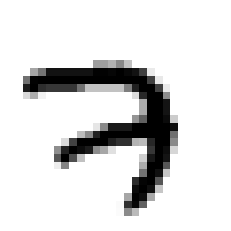

In [136]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

The labels are the class IDs (represent as uinf8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a ```class_names``` array:

In [137]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [138]:
X_valid.shape

(5000, 28, 28)

In [139]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

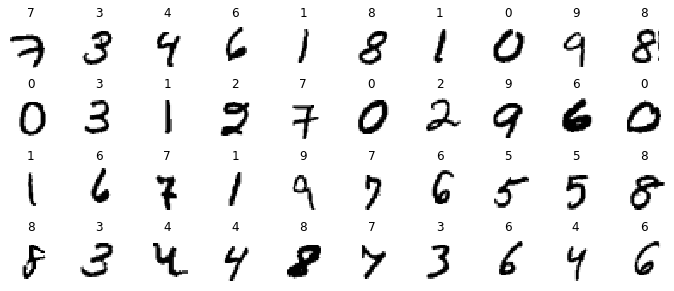

In [140]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration.

In [141]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.lr, 
                                self.model.optimizer.lr*self.factor)

In [142]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [143]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [144]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=1e-3),
             # Updated "accuracy" into "sparse_categorical_accuracy" 
              # https://github.com/tensorflow/tensorflow/issues/41958
             metrics=["sparse_categorical_accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now, let's train the model for just 1 epoch:

In [145]:
history = model.fit(X_train, y_train, epochs=1,
                   validation_data=(X_valid, y_valid),
                   callbacks=[expon_lr])

1719/1719 [==============================] - 6s 3ms/step - loss: nan - sparse_categorical_accuracy: 0.5686 - val_loss: nan - val_sparse_categorical_accuracy: 0.0958


Text(0, 0.5, 'Loss')

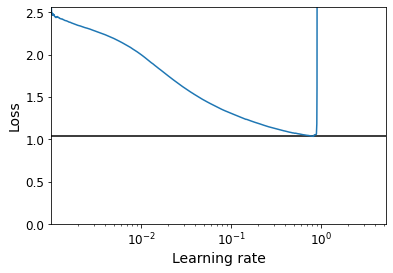

In [146]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [147]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [148]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [149]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=8e-1),
              # Updated "accuracy" into "sparse_categorical_accuracy" 
              # https://github.com/tensorflow/tensorflow/issues/41958
             metrics=["sparse_categorical_accuracy"])

In [150]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [151]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid),
                   callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.1990 - val_sparse_categorical_accuracy: 0.9466
Epoch 2/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9446 - val_loss: 0.1614 - val_sparse_categorical_accuracy: 0.9590
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1569 - sparse_categorical_accuracy: 0.9561 - val_loss: 0.1834 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.1525 - val_sparse_categorical_accuracy: 0.9600
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1167 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.1550 - val_sparse_categorical_accuracy: 0.9604
Epoch 6/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1236 -

In [152]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9551


[0.17670869827270508, 0.9550999999046326]

In [153]:
sklearn.metrics.accuracy_score(y_test, model.predict_classes(X_test))

0.9551

In [99]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
